# [Artificial Neural Networks - Assignment](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxhcnRpZmljaWFsbmV1cmFsbmV0d29ya3Nhbm58Z3g6MzZmMzBjY2ZmN2EyMmMyYQ)

Course: https://sites.google.com/site/artificialneuralnetworksann/lecture-notes


## Q1.
a. Create the Multi-layer Perceptron Neural Network / Back-propagation network from scratch in Python using the weight and bias updation for solving the classification Problem. Also check the linear Separability for AND and XOR problem using the created Multi-layer Perceptron Neural Network algorithm/ Back propagation network.

- **Note:-** Carry out leave-one-out cross-validation (LOOCV) and K-Fold Cross Validationon a simple classification problem. Discuss the best approach amongst the same.

b. Try to Modify the weight and bias updation formula by changing or removing the learning rate used in the Multi-layer Perceptron Neural Network / Back-propagation network to check the impact on the overall performance of the network

In [1]:
import numpy as np
from typeguard import typechecked
from typing import Callable, List

In [2]:
np.random.seed(7)

In [3]:
@typechecked
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

@typechecked
def sigmoid_grad(x: np.ndarray) -> np.ndarray:
    return sigmoid(x) * (1 - sigmoid(x))

In [4]:
@typechecked
def relu(x: np.ndarray) -> np.ndarray:
    return x * (x > 0).astype(x.dtype)

@typechecked
def relu_grad(x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(x.dtype)

In [5]:
@typechecked
def identity(x: np.ndarray) -> np.ndarray:
    return x

@typechecked
def identity_grad(x: np.ndarray) -> np.ndarray:
    return np.ones_like(x)

In [90]:
# avoid NaN(s)
epsilon = 1e-12

@typechecked
def crossentropy(y: np.ndarray, logits: np.ndarray) -> np.float64:
    assert y.shape == logits.shape, "Both y and logits must have exact same dimensions"
    m = y.shape[0]
    
    y_dash = 1 - y
    logits_dash = 1 - logits
    
    log_hx = np.log(logits + epsilon)
    log_hx_dash = np.log(logits_dash + epsilon)
    
    sample_wise_loss = np.sum((y * log_hx) + (y_dash * log_hx_dash), axis=-1)
    loss = (-1. / m) * np.sum(sample_wise_loss)
    
    return loss 

In [91]:
y = np.array([[1, 0, 1],
              [0, 1, 0],
              [0, 0, 1],
              [1, 0, 0]])
logits =  np.array([[0.7, 0.1, 0.2],
                    [0.6, 0.4, 0.0],
                    [0.3, 0.1, 0.6],
                    [0.2, 0.2, 0.6]])
crossentropy(y, logits)

1.906447028684372

In [92]:
y = np.array([[1],
              [0],
              [0],
              [1]])
logits =  np.array([[0.7],
                    [0.6],
                    [0.3],
                    [0.2]])
crossentropy(y, logits)

0.8097696330438409

In [93]:
@typechecked
def initialize_weights(shape: tuple) -> np.ndarray:
    out_dim, in_dim = shape
    e_init = np.sqrt(6) / np.sqrt(out_dim + in_dim)
    
    weights = np.random.uniform(-e_init, e_init, size=shape)
    return weights

In [94]:
shape = (9, 3)
initialize_weights(shape)

array([[-0.31259593,  0.01712026,  0.17326651],
       [ 0.36983286, -0.57028477, -0.36307187],
       [ 0.36578104,  0.52729273, -0.24941146],
       [-0.62462253, -0.5119304 ,  0.41221313],
       [-0.52068128, -0.40345017, -0.4374128 ],
       [-0.12159832,  0.20044481, -0.51272173],
       [-0.03974095,  0.60591381, -0.00697332],
       [-0.01685038,  0.32948878,  0.08007476],
       [-0.08195658,  0.48319171, -0.50773153]])

In [95]:
class Layer:
    @typechecked
    def __init__(self, input_dim: int, output_dim: int, 
                 activation: Callable = identity, 
                 activation_grad: Callable = identity_grad):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.wb = initialize_weights((output_dim, input_dim + 1))
        self.activation = activation
        self.activation_grad = activation_grad
    
    @typechecked
    def get_size(self) -> tuple:
        return self.input_dim, self.output_dim
    
    def forward(self, inputs):
        n_samples, n_features = inputs.shape

        assert n_features == self.input_dim, "Inputs must be a"\
            f" n x {self.input_dim} matrix"
        
        ones = np.ones((n_samples, 1))
        
        inputs = np.hstack([ones, inputs])

        outputs = self.activation(inputs @ self.wb.T)
        return outputs
    
    def backward(self, inputs, targets, precomputed=True):
        n_samples, n_features = inputs.shape

        assert n_features == self.input_dim, "Inputs must be a"\
            f" n x {self.input_dim} matrix"
        
        if precomputed:
            delta = targets
        else:
            delta = targets - self.forward(inputs)
        
        ones = np.ones((n_samples, 1))
        inputs = np.hstack([ones, inputs])
        grad_outputs = self.activation_grad(inputs @ self.wb.T)
        
        if precomputed:
            delta = delta[:, 1:]
        
        return delta * grad_outputs

In [96]:
n_samples = 10
n_features = 5
n_neurons = 3

X = np.random.normal(size=(n_samples, n_features))

In [97]:
layer = Layer(n_features, n_neurons, identity, identity_grad)
out = layer.forward(X)
assert out.shape == (n_samples, n_neurons)
out

array([[-1.35939275e+00,  2.17537676e-01,  4.99078857e-01],
       [ 6.74661903e-05,  2.95559849e+00,  4.67373562e-01],
       [ 1.30367203e+00,  4.03584875e-01, -2.24290974e-01],
       [-2.68493746e-01,  1.02960071e+00,  2.77442828e-02],
       [ 1.81391389e+00,  1.54949493e+00,  3.06716911e-01],
       [ 1.71347355e+00, -1.45819886e+00, -1.63759298e+00],
       [-8.59283052e-01, -3.96462101e-02, -1.27789708e-01],
       [ 1.31211329e+00,  9.60058818e-01,  7.73788717e-01],
       [-1.18222621e+00,  1.46656962e+00,  2.39591282e+00],
       [-1.68531467e-01,  7.81393138e-01,  2.65829780e-01]])

In [98]:
n_samples = 4
input_dim = 5
output_dim = 3

X = np.random.normal(size=(n_samples, input_dim))
y = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [1., 0., 0.],
              [0., 0., 1.]])

In [99]:
layer = Layer(input_dim, output_dim, sigmoid, sigmoid_grad)
layer.forward(X)

array([[0.75596437, 0.60427218, 0.15745496],
       [0.23168431, 0.74151881, 0.41555002],
       [0.72895932, 0.81574782, 0.38515137],
       [0.92718053, 0.04044711, 0.85268653]])

In [100]:
layer.backward(X, y, precomputed=False)

array([[ 0.04502024, -0.14449798, -0.02088843],
       [-0.04124136,  0.04954274, -0.10092389],
       [ 0.05355158, -0.1226096 , -0.09120762],
       [-0.06260025, -0.0015698 ,  0.01850437]])

In [101]:
n_samples = 4
input_dim_layer1 = 10
output_dim_layer1 = input_dim_layer2 = 5
output_dim_layer2 = 3

X = np.random.normal(size=(n_samples, input_dim_layer1))
y = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [1., 0., 0.],
              [0., 0., 1.]])
assert y.shape[1] == output_dim_layer2

In [102]:
mlp_layers = [
    Layer(input_dim_layer1, output_dim_layer1, identity, identity_grad),
    Layer(input_dim_layer2, output_dim_layer2, identity, identity_grad)
]

In [103]:
h = mlp_layers[0].forward(X)
t = mlp_layers[1].forward(h)

In [104]:
targets = y
grads2 = mlp_layers[1].backward(h, targets, precomputed=False)
targets = grads2 @ mlp_layers[1].wb
grads1 = mlp_layers[0].backward(X, targets)
targets = grads1 @ mlp_layers[0].wb

In [105]:
grads1

array([[ 1.35024404,  0.7229292 ,  0.89784282, -0.09469278, -0.23816397],
       [ 0.05777604,  0.37316806,  0.05252422,  0.12280288,  0.42845905],
       [ 0.13779863,  0.49897895,  0.3337209 , -0.13678874,  0.67388724],
       [ 1.31146502,  0.73724607,  1.26158707, -0.57103144,  0.07839665]])

In [106]:
grads2

array([[ 1.17839673,  0.79026186,  0.45844476],
       [-0.13346103,  0.50792597, -0.63435454],
       [ 0.21866453,  0.6551931 , -1.06815196],
       [ 1.6905785 ,  0.79109643, -0.14439637]])

In [107]:
class NN:
    @typechecked
    def __init__(self, layers: List[Layer], alpha: float):
        assert len(layers) > 0, "Number of layers should be atleast one"
        NN.check_shapes(layers)
        
        self.layers = layers
        self.alpha = alpha
    
    @staticmethod
    def check_shapes(layers: List[Layer]):
        prev_layer = layers[0]
        for layer in layers[1:]:
            _, prev_output = prev_layer.get_size()
            this_input, _ = layer.get_size()
            
            assert prev_output == this_input, "Layer input size must exactly"\
                " match output shape of the preceeding layer"
            
            prev_layer = layer
    
    @typechecked
    def forward(self, inputs: np.ndarray) -> List[np.ndarray]:
        out = inputs
        acts = [inputs]
        for layer in self.layers:
            out = layer.forward(out)
            acts.append(out)
        return acts
    
    @typechecked
    def __call__(self, inputs: np.ndarray) -> np.ndarray:
        return self.forward(inputs)[-1]
    
    @typechecked
    def backward(self, inputs: np.ndarray, targets: np.ndarray) -> (List[np.ndarray], List[np.ndarray]):
        acts = self.forward(inputs)
        last = True

        grads = []
        for i in range(len(self.layers) - 1, -1, -1):
            grad = self.layers[i].backward(acts[i], targets, precomputed=not last)
            targets = grad @ self.layers[i].wb
            grads.append(grad)

            if last:
                last = not last
        grads.reverse()
        return acts, grads
    
    @typechecked
    def __str__(self) -> str:
        s = ''
        for i, layer in enumerate(self.layers):
            s += f"Layer {i}: {layer.get_size()}\n"
        return s
    
    @typechecked
    def update_weights(self, deltas: List[np.ndarray]):
        for layer, delta in zip(self.layers, deltas):
            layer.wb = layer.wb + self.alpha * delta
    
    @typechecked
    def calculate_deltas(self, X: np.ndarray, y: np.ndarray) -> List[np.ndarray]:
        n_samples = X.shape[0]
        acts, grads = self.backward(X, y)
        deltas = []
        for act, grad in zip(acts, grads):
            ones = np.ones((n_samples, 1))
            act = np.hstack([ones, act])
            
            delta = (act.T @ grad).T
            deltas.append(delta)
        return deltas
    
    @typechecked
    def train(self, X: np.ndarray, y: np.ndarray, epochs: int):
        for e in range(1, epochs + 1):
            deltas = self.calculate_deltas(X, y)
            self.update_weights(deltas)
            
            logits = self(X)
            print(f"Epoch {e}: Cross-entropy loss: {crossentropy(y, logits)}")

In [122]:
n_samples = 100
input_dim_layer1 = 20
output_dim_layer1 = input_dim_layer2 = 10
output_dim_layer2 = input_dim_layer3 = 5
output_dim_layer3 = input_dim_layer4 = 4
num_classes = output_dim_layer4 = 3

X = np.random.normal(size=(n_samples, input_dim_layer1))
y = np.random.randint(0, num_classes, size=(n_samples))

eye = np.eye(num_classes)
y = eye[y] # encode as one-hot

X.shape, y.shape

((100, 20), (100, 3))

In [127]:
net = NN([
    Layer(input_dim_layer1, output_dim_layer1, sigmoid, sigmoid_grad),
    Layer(input_dim_layer2, output_dim_layer2, sigmoid, sigmoid_grad),
    Layer(input_dim_layer3, output_dim_layer3, sigmoid, sigmoid_grad),
    Layer(input_dim_layer4, output_dim_layer4, sigmoid, sigmoid_grad)
], alpha=0.01)
print(net)

Layer 0: (20, 10)
Layer 1: (10, 5)
Layer 2: (5, 4)
Layer 3: (4, 3)



In [128]:
acts, grads = net.backward(X, y)
deltas = net.calculate_deltas(X, y)

In [130]:
net.train(X, y, 200)

Epoch 1: Cross-entropy loss: 1.8475250599522612
Epoch 2: Cross-entropy loss: 1.8471164997157843
Epoch 3: Cross-entropy loss: 1.8467052782925795
Epoch 4: Cross-entropy loss: 1.8462913880435106
Epoch 5: Cross-entropy loss: 1.8458748215654373
Epoch 6: Cross-entropy loss: 1.84545557169748
Epoch 7: Cross-entropy loss: 1.8450336315273352
Epoch 8: Cross-entropy loss: 1.844608994397638
Epoch 9: Cross-entropy loss: 1.8441816539123668
Epoch 10: Cross-entropy loss: 1.8437516039432904
Epoch 11: Cross-entropy loss: 1.84331883863645
Epoch 12: Cross-entropy loss: 1.842883352418678
Epoch 13: Cross-entropy loss: 1.8424451400041508
Epoch 14: Cross-entropy loss: 1.842004196400965
Epoch 15: Cross-entropy loss: 1.8415605169177451
Epoch 16: Cross-entropy loss: 1.841114097170266
Epoch 17: Cross-entropy loss: 1.8406649330881035
Epoch 18: Cross-entropy loss: 1.840213020921288
Epoch 19: Cross-entropy loss: 1.8397583572469782
Epoch 20: Cross-entropy loss: 1.8393009389761357
Epoch 21: Cross-entropy loss: 1.838840

Epoch 189: Cross-entropy loss: 1.7351695274150947
Epoch 190: Cross-entropy loss: 1.7345336917282228
Epoch 191: Cross-entropy loss: 1.733899206186733
Epoch 192: Cross-entropy loss: 1.7332660829540285
Epoch 193: Cross-entropy loss: 1.7326343337632155
Epoch 194: Cross-entropy loss: 1.7320039699295833
Epoch 195: Cross-entropy loss: 1.731375002363565
Epoch 196: Cross-entropy loss: 1.7307474415841488
Epoch 197: Cross-entropy loss: 1.7301212977327414
Epoch 198: Cross-entropy loss: 1.7294965805874314
Epoch 199: Cross-entropy loss: 1.7288732995776661
Epoch 200: Cross-entropy loss: 1.7282514637992845


In [132]:
net = NN([
    Layer(input_dim_layer1, output_dim_layer1, sigmoid, sigmoid_grad),
    Layer(input_dim_layer2, output_dim_layer2, sigmoid, sigmoid_grad),
    Layer(input_dim_layer3, output_dim_layer3, sigmoid, sigmoid_grad),
    Layer(input_dim_layer4, output_dim_layer4, sigmoid, sigmoid_grad)
], alpha=0.1)
print(net)
net.train(X, y, 1000)

Layer 0: (20, 10)
Layer 1: (10, 5)
Layer 2: (5, 4)
Layer 3: (4, 3)

Epoch 1: Cross-entropy loss: 1.9142808395787878
Epoch 2: Cross-entropy loss: 1.9088382781269377
Epoch 3: Cross-entropy loss: 1.9086630851158506
Epoch 4: Cross-entropy loss: 1.908501166518512
Epoch 5: Cross-entropy loss: 1.908340786817641
Epoch 6: Cross-entropy loss: 1.9081817996801684
Epoch 7: Cross-entropy loss: 1.9080238877359619
Epoch 8: Cross-entropy loss: 1.9078667514989827
Epoch 9: Cross-entropy loss: 1.9077100961700253
Epoch 10: Cross-entropy loss: 1.9075536316880621
Epoch 11: Cross-entropy loss: 1.9073970712399857
Epoch 12: Cross-entropy loss: 1.9072401299429556
Epoch 13: Cross-entropy loss: 1.9070825235415143
Epoch 14: Cross-entropy loss: 1.9069239671234963
Epoch 15: Cross-entropy loss: 1.9067641738426722
Epoch 16: Cross-entropy loss: 1.9066028536378468
Epoch 17: Cross-entropy loss: 1.906439711938075
Epoch 18: Cross-entropy loss: 1.9062744483436282
Epoch 19: Cross-entropy loss: 1.9061067552722182
Epoch 20: Cro

Epoch 184: Cross-entropy loss: 1.2901062299653083
Epoch 185: Cross-entropy loss: 1.28802118794889
Epoch 186: Cross-entropy loss: 1.285986303651251
Epoch 187: Cross-entropy loss: 1.2840053315904532
Epoch 188: Cross-entropy loss: 1.2820797700261466
Epoch 189: Cross-entropy loss: 1.2802092550105575
Epoch 190: Cross-entropy loss: 1.2783919120210678
Epoch 191: Cross-entropy loss: 1.2766249192967025
Epoch 192: Cross-entropy loss: 1.2749048860934395
Epoch 193: Cross-entropy loss: 1.2732281980837374
Epoch 194: Cross-entropy loss: 1.271591189247841
Epoch 195: Cross-entropy loss: 1.2699902621445431
Epoch 196: Cross-entropy loss: 1.2684219159079162
Epoch 197: Cross-entropy loss: 1.2668827548886608
Epoch 198: Cross-entropy loss: 1.2653694630294177
Epoch 199: Cross-entropy loss: 1.2638787782450618
Epoch 200: Cross-entropy loss: 1.2624074585653826
Epoch 201: Cross-entropy loss: 1.260952253337229
Epoch 202: Cross-entropy loss: 1.2595098743537032
Epoch 203: Cross-entropy loss: 1.2580769710093014
Epoch

Epoch 360: Cross-entropy loss: 0.45421901840997586
Epoch 361: Cross-entropy loss: 0.46461592501926346
Epoch 362: Cross-entropy loss: 0.44286895859407927
Epoch 363: Cross-entropy loss: 0.45022887990022287
Epoch 364: Cross-entropy loss: 0.43155560576049995
Epoch 365: Cross-entropy loss: 0.4319880535630514
Epoch 366: Cross-entropy loss: 0.4248338119519371
Epoch 367: Cross-entropy loss: 0.4209685216731192
Epoch 368: Cross-entropy loss: 0.4199848188473376
Epoch 369: Cross-entropy loss: 0.4151863403370161
Epoch 370: Cross-entropy loss: 0.41268706053584703
Epoch 371: Cross-entropy loss: 0.4096671122084496
Epoch 372: Cross-entropy loss: 0.40727736084754507
Epoch 373: Cross-entropy loss: 0.40478602432787264
Epoch 374: Cross-entropy loss: 0.40208952749042004
Epoch 375: Cross-entropy loss: 0.40048105424773717
Epoch 376: Cross-entropy loss: 0.39750292614940186
Epoch 377: Cross-entropy loss: 0.396232413843577
Epoch 378: Cross-entropy loss: 0.39290228647411995
Epoch 379: Cross-entropy loss: 0.392354

Epoch 530: Cross-entropy loss: 0.2574969218536228
Epoch 531: Cross-entropy loss: 0.2571165543656925
Epoch 532: Cross-entropy loss: 0.2567387445607393
Epoch 533: Cross-entropy loss: 0.2563634297852763
Epoch 534: Cross-entropy loss: 0.2559905382461094
Epoch 535: Cross-entropy loss: 0.2556199886199847
Epoch 536: Cross-entropy loss: 0.2552516896883496
Epoch 537: Cross-entropy loss: 0.25488553999886016
Epoch 538: Cross-entropy loss: 0.2545214275545623
Epoch 539: Cross-entropy loss: 0.2541592295308166
Epoch 540: Cross-entropy loss: 0.2537988120190524
Epoch 541: Cross-entropy loss: 0.2534400297952821
Epoch 542: Cross-entropy loss: 0.2530827261100263
Epoch 543: Cross-entropy loss: 0.2527267324948464
Epoch 544: Cross-entropy loss: 0.25237186857907806
Epoch 545: Cross-entropy loss: 0.2520179419085963
Epoch 546: Cross-entropy loss: 0.2516647477564866
Epoch 547: Cross-entropy loss: 0.2513120689133729
Epoch 548: Cross-entropy loss: 0.2509596754427847
Epoch 549: Cross-entropy loss: 0.250607324384344

Epoch 694: Cross-entropy loss: 0.1878620577570954
Epoch 695: Cross-entropy loss: 0.18772257842541362
Epoch 696: Cross-entropy loss: 0.18758400545564743
Epoch 697: Cross-entropy loss: 0.18744632448120602
Epoch 698: Cross-entropy loss: 0.1873095215490912
Epoch 699: Cross-entropy loss: 0.1871735831028876
Epoch 700: Cross-entropy loss: 0.18703849596660932
Epoch 701: Cross-entropy loss: 0.18690424732935637
Epoch 702: Cross-entropy loss: 0.18677082473073447
Epoch 703: Cross-entropy loss: 0.18663821604699482
Epoch 704: Cross-entropy loss: 0.1865064094778521
Epoch 705: Cross-entropy loss: 0.18637539353394603
Epoch 706: Cross-entropy loss: 0.1862451570249075
Epoch 707: Cross-entropy loss: 0.18611568904799713
Epoch 708: Cross-entropy loss: 0.18598697897728658
Epoch 709: Cross-entropy loss: 0.1858590164533503
Epoch 710: Cross-entropy loss: 0.1857317913734415
Epoch 711: Cross-entropy loss: 0.1856052938821272
Epoch 712: Cross-entropy loss: 0.1854795143623562
Epoch 713: Cross-entropy loss: 0.1853544

Epoch 867: Cross-entropy loss: 0.17144026162513112
Epoch 868: Cross-entropy loss: 0.17137390369084213
Epoch 869: Cross-entropy loss: 0.17130779639976176
Epoch 870: Cross-entropy loss: 0.17124193994315628
Epoch 871: Cross-entropy loss: 0.17117633455153414
Epoch 872: Cross-entropy loss: 0.17111098049514936
Epoch 873: Cross-entropy loss: 0.17104587808451835
Epoch 874: Cross-entropy loss: 0.17098102767095597
Epoch 875: Cross-entropy loss: 0.17091642964712475
Epoch 876: Cross-entropy loss: 0.17085208444760366
Epoch 877: Cross-entropy loss: 0.17078799254947263
Epoch 878: Cross-entropy loss: 0.17072415447291384
Epoch 879: Cross-entropy loss: 0.17066057078183242
Epoch 880: Cross-entropy loss: 0.17059724208449353
Epoch 881: Cross-entropy loss: 0.1705341690341791
Epoch 882: Cross-entropy loss: 0.17047135232986207
Epoch 883: Cross-entropy loss: 0.17040879271690174
Epoch 884: Cross-entropy loss: 0.17034649098775564
Epoch 885: Cross-entropy loss: 0.170284447982715
Epoch 886: Cross-entropy loss: 0.1

**AND Problem**

In [140]:
# AND Problem
X = np.array([[0., 0.], 
              [0., 1.], 
              [1., 0.], 
              [1., 1.]])
y = np.array([[0.], 
              [0.], 
              [0.], 
              [1.]])

and_net = NN([
    Layer(2, 1, sigmoid, sigmoid_grad)
], alpha=0.8)

and_net.train(X, y, 500)

Epoch 1: Cross-entropy loss: 0.9306897885969259
Epoch 2: Cross-entropy loss: 0.8111402186816637
Epoch 3: Cross-entropy loss: 0.7313727411244799
Epoch 4: Cross-entropy loss: 0.6799232034874192
Epoch 5: Cross-entropy loss: 0.644815567177878
Epoch 6: Cross-entropy loss: 0.6186776909267683
Epoch 7: Cross-entropy loss: 0.5975953723457854
Epoch 8: Cross-entropy loss: 0.5795329802985519
Epoch 9: Cross-entropy loss: 0.5634176640574659
Epoch 10: Cross-entropy loss: 0.5486730292854197
Epoch 11: Cross-entropy loss: 0.534981955015133
Epoch 12: Cross-entropy loss: 0.5221627764931983
Epoch 13: Cross-entropy loss: 0.5101034661233482
Epoch 14: Cross-entropy loss: 0.4987268831068852
Epoch 15: Cross-entropy loss: 0.4879731516488635
Epoch 16: Cross-entropy loss: 0.4777913922660634
Epoch 17: Cross-entropy loss: 0.4681362674234407
Epoch 18: Cross-entropy loss: 0.45896672930759996
Epoch 19: Cross-entropy loss: 0.45024558308192114
Epoch 20: Cross-entropy loss: 0.44193923460563544
Epoch 21: Cross-entropy loss

Epoch 245: Cross-entropy loss: 0.12097751549756408
Epoch 246: Cross-entropy loss: 0.12067738410447544
Epoch 247: Cross-entropy loss: 0.12037919965944206
Epoch 248: Cross-entropy loss: 0.12008294235667089
Epoch 249: Cross-entropy loss: 0.11978859266218068
Epoch 250: Cross-entropy loss: 0.11949613130912404
Epoch 251: Cross-entropy loss: 0.11920553929320621
Epoch 252: Cross-entropy loss: 0.11891679786819775
Epoch 253: Cross-entropy loss: 0.11862988854154033
Epoch 254: Cross-entropy loss: 0.11834479307004135
Epoch 255: Cross-entropy loss: 0.11806149345565731
Epoch 256: Cross-entropy loss: 0.117779971941362
Epoch 257: Cross-entropy loss: 0.11750021100709888
Epoch 258: Cross-entropy loss: 0.11722219336581509
Epoch 259: Cross-entropy loss: 0.11694590195957491
Epoch 260: Cross-entropy loss: 0.11667131995575128
Epoch 261: Cross-entropy loss: 0.11639843074329333
Epoch 262: Cross-entropy loss: 0.11612721792906817
Epoch 263: Cross-entropy loss: 0.11585766533427533
Epoch 264: Cross-entropy loss: 0.

Epoch 420: Cross-entropy loss: 0.08716333599633119
Epoch 421: Cross-entropy loss: 0.08703822532095472
Epoch 422: Cross-entropy loss: 0.08691360176946114
Epoch 423: Cross-entropy loss: 0.08678946231939991
Epoch 424: Cross-entropy loss: 0.08666580397384704
Epoch 425: Cross-entropy loss: 0.08654262376113349
Epoch 426: Cross-entropy loss: 0.08641991873457694
Epoch 427: Cross-entropy loss: 0.08629768597221711
Epoch 428: Cross-entropy loss: 0.08617592257655463
Epoch 429: Cross-entropy loss: 0.08605462567429253
Epoch 430: Cross-entropy loss: 0.08593379241608193
Epoch 431: Cross-entropy loss: 0.08581341997627026
Epoch 432: Cross-entropy loss: 0.08569350555265312
Epoch 433: Cross-entropy loss: 0.0855740463662288
Epoch 434: Cross-entropy loss: 0.0854550396609563
Epoch 435: Cross-entropy loss: 0.08533648270351635
Epoch 436: Cross-entropy loss: 0.08521837278307515
Epoch 437: Cross-entropy loss: 0.08510070721105115
Epoch 438: Cross-entropy loss: 0.08498348332088512
Epoch 439: Cross-entropy loss: 0.

In [139]:
and_net(X)

array([[0.00126662],
       [0.09198506],
       [0.09198505],
       [0.89001193]])

In [148]:
(and_net(X) > 0.5).astype(np.float32)

array([[0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

**XOr Problem**

In [145]:
# AND Problem
X = np.array([[0., 0.], 
              [0., 1.], 
              [1., 0.], 
              [1., 1.]])
y = np.array([[0.], 
              [1.], 
              [1.], 
              [0.]])

xor_net = NN([
    Layer(2, 5, sigmoid, sigmoid_grad),
    Layer(5, 1, sigmoid, sigmoid_grad)
], alpha=0.9)

xor_net.train(X, y, 500)

Epoch 1: Cross-entropy loss: 0.6965205329077455
Epoch 2: Cross-entropy loss: 0.6926453280976261
Epoch 3: Cross-entropy loss: 0.6919231949949647
Epoch 4: Cross-entropy loss: 0.691769436553227
Epoch 5: Cross-entropy loss: 0.6917131495924183
Epoch 6: Cross-entropy loss: 0.6916731244158421
Epoch 7: Cross-entropy loss: 0.6916355782612378
Epoch 8: Cross-entropy loss: 0.6915982040154054
Epoch 9: Cross-entropy loss: 0.6915606228075193
Epoch 10: Cross-entropy loss: 0.6915227713532262
Epoch 11: Cross-entropy loss: 0.6914846345429876
Epoch 12: Cross-entropy loss: 0.691446203095734
Epoch 13: Cross-entropy loss: 0.6914074676899059
Epoch 14: Cross-entropy loss: 0.6913684185167901
Epoch 15: Cross-entropy loss: 0.6913290454287521
Epoch 16: Cross-entropy loss: 0.691289338053534
Epoch 17: Cross-entropy loss: 0.6912492858473123
Epoch 18: Cross-entropy loss: 0.6912088781146106
Epoch 19: Cross-entropy loss: 0.6911681040132365
Epoch 20: Cross-entropy loss: 0.6911269525528154
Epoch 21: Cross-entropy loss: 0.

Epoch 176: Cross-entropy loss: 0.6566071553189814
Epoch 177: Cross-entropy loss: 0.6557403388029707
Epoch 178: Cross-entropy loss: 0.6548492811147826
Epoch 179: Cross-entropy loss: 0.6539332692176792
Epoch 180: Cross-entropy loss: 0.6529915725860227
Epoch 181: Cross-entropy loss: 0.6520234432112381
Epoch 182: Cross-entropy loss: 0.6510281156567613
Epoch 183: Cross-entropy loss: 0.6500048071667777
Epoch 184: Cross-entropy loss: 0.648952717833827
Epoch 185: Cross-entropy loss: 0.6478710308306234
Epoch 186: Cross-entropy loss: 0.6467589127116901
Epoch 187: Cross-entropy loss: 0.6456155137906775
Epoch 188: Cross-entropy loss: 0.6444399685994661
Epoch 189: Cross-entropy loss: 0.6432313964353904
Epoch 190: Cross-entropy loss: 0.6419889020031289
Epoch 191: Cross-entropy loss: 0.6407115761579834
Epoch 192: Cross-entropy loss: 0.6393984967574345
Epoch 193: Cross-entropy loss: 0.6380487296279629
Epoch 194: Cross-entropy loss: 0.6366613296542082
Epoch 195: Cross-entropy loss: 0.6352353419975525
E

Epoch 413: Cross-entropy loss: 0.138709218179218
Epoch 414: Cross-entropy loss: 0.13810555549262532
Epoch 415: Cross-entropy loss: 0.13750810143544662
Epoch 416: Cross-entropy loss: 0.1369167622739102
Epoch 417: Cross-entropy loss: 0.13633144605939684
Epoch 418: Cross-entropy loss: 0.1357520625891367
Epoch 419: Cross-entropy loss: 0.13517852336783404
Epoch 420: Cross-entropy loss: 0.13461074157019745
Epoch 421: Cross-entropy loss: 0.13404863200435568
Epoch 422: Cross-entropy loss: 0.13349211107613795
Epoch 423: Cross-entropy loss: 0.13294109675419924
Epoch 424: Cross-entropy loss: 0.1323955085359722
Epoch 425: Cross-entropy loss: 0.13185526741442408
Epoch 426: Cross-entropy loss: 0.13132029584560098
Epoch 427: Cross-entropy loss: 0.13079051771694217
Epoch 428: Cross-entropy loss: 0.13026585831634283
Epoch 429: Cross-entropy loss: 0.12974624430195122
Epoch 430: Cross-entropy loss: 0.1292316036726802
Epoch 431: Cross-entropy loss: 0.128721865739416
Epoch 432: Cross-entropy loss: 0.128216

In [150]:
xor_net(X) 

array([[0.09345264],
       [0.90360452],
       [0.89476925],
       [0.09408388]])

In [151]:
(xor_net(X) > 0.5).astype(np.float32)

array([[0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

## Q2.

Implement the problem mentioned below in Python and also try to modify the created network for the given problem by increasing the number of layers in network to check the impact on the overall performance of the model.

**Problem:-**
A network is created when we multiple neurons stack together. Let us take an example of a neural network simulating an XNOR function.

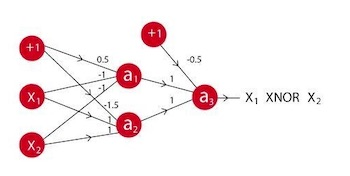

You can see that the last neuron takes input from two neurons before it. The activation function for all the neurons is given by:

$ f(x) = \left\{ \begin{array}{ll}
      0 & for & x\leq 0 \\
      1 & for & x\geq 0 \\
\end{array}
\right. $

Suppose X1 is 0 and X2 is 1, what will be the output for the above neural network? <br/>
A) 0 <br/>
B) 1

In [1]:
import numpy as np
from typeguard import typechecked
from typing import List, Callable, Union

Feed forward network layer.

In [2]:
class Layer:
    @typechecked
    def __init__(self, w: np.ndarray, b: np.ndarray, 
                 activation: Union[Callable, None] = None):
        assert w.ndim == 2, "Weights must be 2D matrix"
        assert b.ndim == 1, "Biases must be 1D vector"
        assert w.shape[0] == b.shape[0], "Weights and biases must"\
            " conform to same number of neurons"

        self.weights = w
        self.biases = b

        self.activation = activation
    
    @typechecked
    def get_size(self) -> tuple:
        output_size, input_size = self.weights.shape
        return input_size, output_size

    @typechecked
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        n_samples, n_features = inputs.shape

        assert n_features == self.weights.shape[-1], "Inputs must be a"\
            f" n x {n_features} matrix"
        n_neurons = self.weights.shape[0]

        ones = np.ones((n_samples, 1))
        
        inputs = np.hstack([ones, inputs])
        b = np.expand_dims(self.biases, -1)
        wb = np.hstack([b, self.weights])

        output = inputs @ wb.T
        if self.activation is not None:
            return self.activation(output)
        else:
            return output

    @typechecked
    def __call__(self, inputs: np.ndarray) -> np.ndarray:
        return self.forward(inputs)

Set random seed for determininstic results.

In [3]:
np.random.seed(7)

In [4]:
n_samples = 10
n_features = 5
n_neurons = 3

X = np.random.normal(size=(n_samples, n_features))
w = np.random.random(size=(n_neurons, n_features))
b = np.random.random(size=(n_neurons, ))

In [5]:
layer1 = Layer(w, b)
layer1_output = layer1(X)
assert layer1.get_size() == (n_features, n_neurons)

In [6]:
class Net:
    @typechecked
    def __init__(self, layers: List[Layer]):
        assert len(layers) > 0, "Number of layers should be atleast one"
        Net.check_shapes(layers)
        self.layers = layers
            
    @staticmethod
    def check_shapes(layers: List[Layer]):
        prev_layer = layers[0]
        for layer in layers[1:]:
            _, prev_output = prev_layer.get_size()
            this_input, _ = layer.get_size()
            
            assert prev_output == this_input, "Layer input size must exactly"\
                " match output shape of the preceeding layer"
            
            prev_layer = layer
    
    @typechecked
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs
    
    @typechecked
    def __call__(self, inputs: np.ndarray) -> np.ndarray:
        return self.forward(inputs)

In [7]:
n_samples = 10
n_features = 5
n_neurons_layer1 = 3
n_neurons_layer2 = 5
n_neurons_layer3 = 1

X = np.random.normal(size=(n_samples, n_features))

w1 = np.random.random(size=(n_neurons_layer1, n_features))
b1 = np.random.random(size=(n_neurons_layer1, ))

w2 = np.random.random(size=(n_neurons_layer2, n_neurons_layer1))
b2 = np.random.random(size=(n_neurons_layer2, ))

w3 = np.random.random(size=(n_neurons_layer3, n_neurons_layer2))
b3 = np.random.random(size=(n_neurons_layer3, ))

In [8]:
identity = lambda x: x
relu = lambda x: np.maximum(x, 0)

In [9]:
layer1 = Layer(w1, b1, relu)
layer2 = Layer(w2, b2, relu)
layer3 = Layer(w3, b3, identity)

In [10]:
y = layer3(layer2(layer1(X)))
y

array([[1.00138383],
       [5.68665987],
       [5.45742112],
       [4.30953155],
       [5.96850311],
       [5.2887552 ],
       [6.18013203],
       [2.46759842],
       [8.05767774],
       [5.08341227]])

In [11]:
net = Net([layer1, layer2, layer3])
assert all(net(X) == y)
net(X)

array([[1.00138383],
       [5.68665987],
       [5.45742112],
       [4.30953155],
       [5.96850311],
       [5.2887552 ],
       [6.18013203],
       [2.46759842],
       [8.05767774],
       [5.08341227]])

Step activation function is defined as:
$ f(x) = \left\{ \begin{array}{ll}
      0 & for & x\leq 0 \\
      1 & for & x\geq 0 \\
\end{array}
\right. $

In [12]:
step = lambda x: (x > 0).astype(x.dtype)

In [13]:
x1 = 0
x2 = 1

w1 = np.array([[-1, -1], [1, 1]])
b1 = np.array([0.5, -1.5])

w2 = np.array([[1, 1]])
b2 = np.array([-0.5])

In [14]:
hidden_layer = Layer(w1, b1, step)
output_layer = Layer(w2, b2, step)
xnor_net = Net([hidden_layer, output_layer])

In [15]:
X = np.array([[x1, x2]])

In [16]:
h = hidden_layer(X)
h

array([[0., 0.]])

In [17]:
t = output_layer(h)
t

array([[0.]])

In [18]:
y = xnor_net(X)
assert all(y == t)
y

array([[0.]])

**XNOR Truth Table**

The XNOR function gives high output (1) results if both of the inputs to the function are the same.

| $ x1 $ | $ x2 $ | $ x1 $ &#9737; $ x2 $ |
| --- | --- | --- |
| 0 | 0 | **1** |
| 0 | 1 | **0** |
| 1 | 0 | **0** |
| 1 | 1 | **1** |

In [19]:
X = np.array([[0, 0], 
              [0, 1], 
              [1, 0], 
              [1, 1]])
xnor_net(X)

array([[1.],
       [0.],
       [0.],
       [1.]])

## Q3.
In training a neural network, you notice that the loss does not decrease in the few starting epochs.

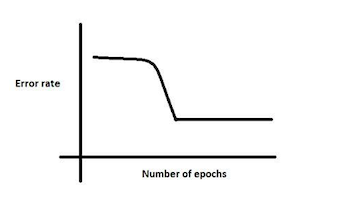

The reasons for this could be:
1. The learning is rate is low
2. Regularization parameter is high
3. Stuck at local minima

What according to you are the probable reasons? Justify your answer regarding the same.

## Q4.
Build and train a ConvNet in Python using TensorFlow / keras for an image classification problem and explain each and every line in the comment section.  

Also, try to improve the performance of the model by applying various hyper parameter tuning to reduce the overfitting or under fitting problem that might occur.

## Q5.
Write code in Python to perform object detection using CNN. 

Also, discuss about various performance evaluation parameters to measure the performance of the object detection algorithms.

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
from math import ceil
from matplotlib import pyplot as plt

**VOC Pascal 2007/2012 Dataset**

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [0]:
images_path = './VOCdevkit/VOC2012/JPEGImages'
masks_path = './VOCdevkit/VOC2012/SegmentationClass'

In [0]:
train_list_path = './VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt'
val_list_path = './VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt'

In [0]:
def read_im_list(path):
    with open(path) as txt_file:
        imlist = txt_file.read()
        imlist = imlist.split('\n')[:-1]
    images_list = [images_path + f"/{i}.jpg" for i in imlist]
    labels_list = [masks_path + f"/{i}.png" for i in imlist]
    return images_list, labels_list

In [0]:
train_images_list, train_labels_list = read_im_list(train_list_path)
val_images_list, val_labels_list = read_im_list(val_list_path)

In [0]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [0]:
colormap = tf.convert_to_tensor(VOC_COLORMAP)
colormap = colormap[None, ...]
gray_colormap = tf.image.rgb_to_grayscale(colormap)
gray_colormap = gray_colormap[0, ..., 0]
colormap = colormap[0]

In [0]:
image_size = (160, 160)
batch_size = 32
num_classes = len(VOC_CLASSES)

In [0]:
@tf.function
def get_image(image_path):
    raw_bytes = tf.io.read_file(image_path)
    rgb_image = tf.image.decode_png(raw_bytes)
    rgb_image = tf.image.resize_with_pad(rgb_image, *image_size)
    rgb_image = tf.cast(rgb_image, tf.float32)
    rgb_image = rgb_image / 255.
    return rgb_image

@tf.function
def get_labels(mask_path):
    raw_bytes = tf.io.read_file(mask_path)
    rgb_image = tf.image.decode_png(raw_bytes)
    gray_image = tf.image.rgb_to_grayscale(rgb_image)
    gray_image = tf.image.resize_with_pad(gray_image, *image_size)
    flat_image = tf.reshape(gray_image, [-1, 1])
    flat_image = tf.cast(flat_image, tf.int32)
    
    labels = tf.math.equal(gray_colormap, flat_image)
    labels = tf.cast(labels, tf.int32)
    labels = tf.argmax(labels, axis=-1)
    labels = tf.reshape(labels, (*image_size, 1))
    return labels

def dataset(impaths, lpaths):
    images_ds = tf.data.Dataset.from_tensor_slices(impaths)
    images_ds = images_ds.map(get_image, tf.data.experimental.AUTOTUNE)

    labels_ds = tf.data.Dataset.from_tensor_slices(lpaths)
    labels_ds = labels_ds.map(get_labels, tf.data.experimental.AUTOTUNE)

    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    return ds

def prepare_dataset(ds):
    ds = ds.cache()
    
    num_samples = tf.data.experimental.cardinality(ds)
    ds = ds.shuffle(num_samples)

    ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [22]:
train_ds = dataset(train_images_list, train_labels_list)
val_ds = dataset(val_images_list, val_labels_list)

train_num_samples = tf.data.experimental.cardinality(train_ds)
val_num_samples = tf.data.experimental.cardinality(val_ds)

print("Number of training samples: ", train_num_samples.numpy())
print("Number of validation samples: ", val_num_samples.numpy())

train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

Number of training samples:  1464
Number of validation samples:  1449


**Xception style U-Net**

Adapted from https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [0]:
def build_model():
    inputs = layers.Input(shape=(*image_size, 3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = models.Model(inputs, outputs)
    return model

In [0]:
tf.keras.backend.clear_session()

In [25]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

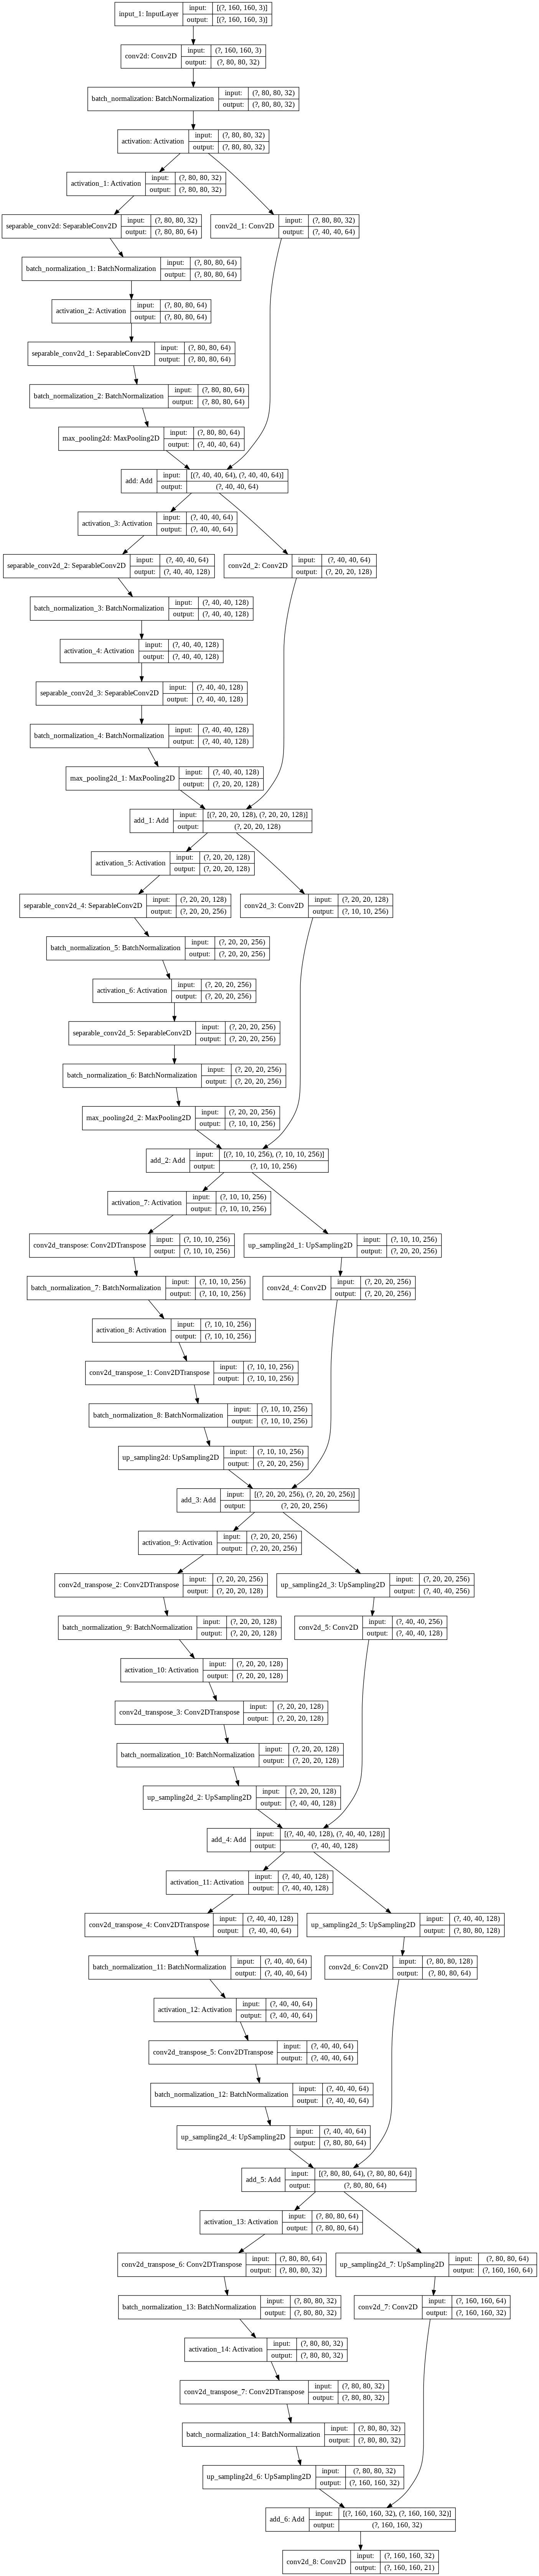

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [0]:
epochs = 30
train_steps = ceil(train_num_samples / batch_size)
val_steps = ceil(val_num_samples / batch_size)

!mkdir voc_pascal_2012_xception_unet
save_path = 'voc_pascal_2012_xception_unet/checkpoint.h5'

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(save_path, 
                                       monitor='val_loss', 
                                       save_best_only=True)
]

In [0]:
model.compile('adam', 'sparse_categorical_crossentropy')

In [28]:
history = model.fit(train_ds, epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_data=val_ds, validation_steps=val_steps)
model.load_weights(save_path)

Epoch 1/50
46/46 [==============================] - 37s 808ms/step - loss: 2.1129 - val_loss: 1.8056
Epoch 2/50
46/46 [==============================] - 24s 527ms/step - loss: 0.7781 - val_loss: 1.0546
Epoch 3/50
46/46 [==============================] - 24s 528ms/step - loss: 0.6573 - val_loss: 1.0631
Epoch 4/50
46/46 [==============================] - 24s 529ms/step - loss: 0.6270 - val_loss: 1.0727
Epoch 5/50
46/46 [==============================] - 24s 528ms/step - loss: 0.6237 - val_loss: 1.1537
Epoch 6/50
46/46 [==============================] - 24s 528ms/step - loss: 0.5991 - val_loss: 1.2443
Epoch 7/50
46/46 [==============================] - 24s 528ms/step - loss: 0.5697 - val_loss: 1.0917
Epoch 8/50
46/46 [==============================] - 24s 528ms/step - loss: 0.5667 - val_loss: 1.0901
Epoch 9/50
46/46 [==============================] - 24s 527ms/step - loss: 0.5531 - val_loss: 0.9446
Epoch 10/50
46/46 [==============================] - 24s 528ms/step - loss: 0.5322 - val_lo

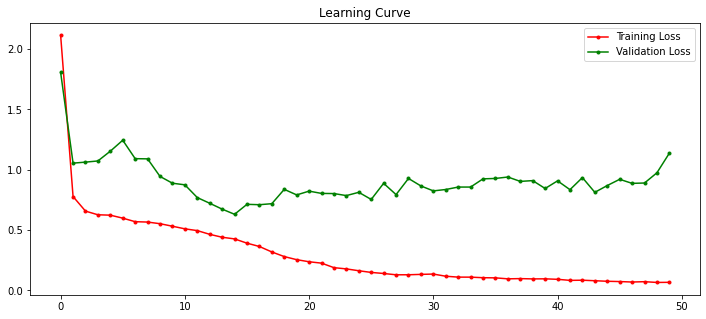

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], 'r.-')
plt.plot(history.history['val_loss'], 'g.-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Learning Curve')
plt.show()

**Visualize Predictions**

In [0]:
def get_single_batch(ds):
    for images, labels in ds:
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1).numpy()

        images = images.numpy()
        labels = labels.numpy()
        break
    return images, labels, preds

In [0]:
def show(image, label, pred):
    plt.figure(figsize=[10, 10])

    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    colorized = colormap.numpy()[label]
    plt.imshow(colorized.reshape(*image_size, 3))
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    colorized = colormap.numpy()[pred]
    plt.imshow(colorized.reshape(*image_size, 3))
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    gray = tf.image.rgb_to_grayscale(image).numpy()[..., 0]
    plt.imshow(gray, cmap='gray')
    plt.imshow(colorized.reshape(*image_size, 3), alpha=0.4)
    plt.title("Superimposed")
    plt.axis("off")

    plt.show()

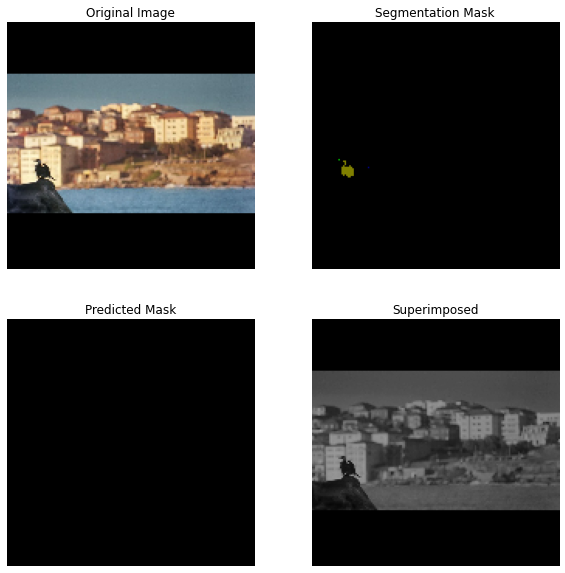

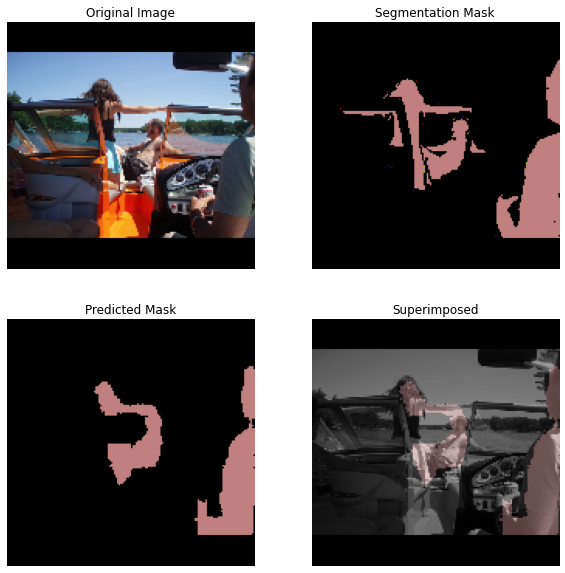

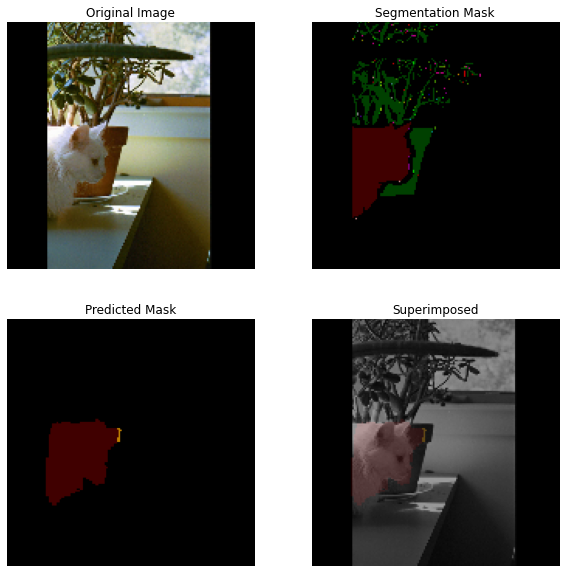

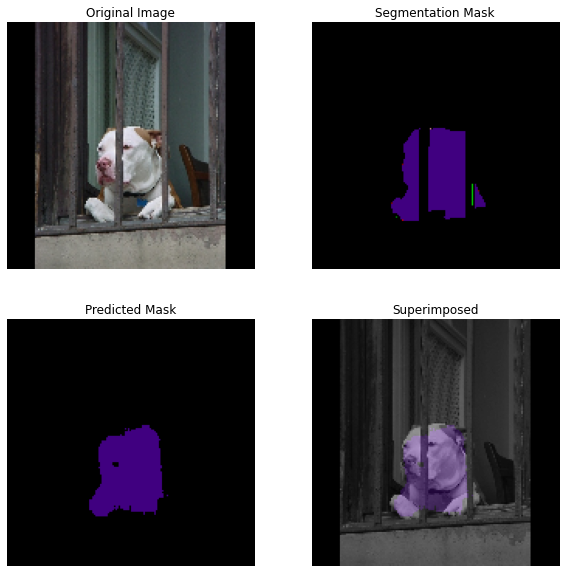

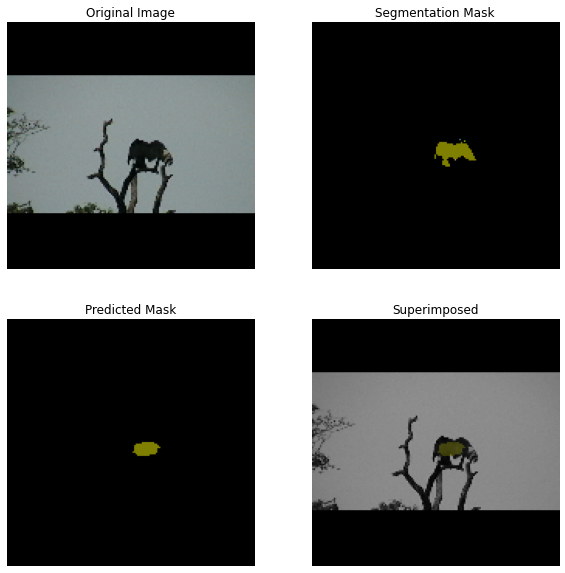

In [48]:
images, labels, preds = get_single_batch(train_ds)
[show(images[idx], labels[idx], preds[idx]) for idx in range(5)]

In [ ]:
print("Validation dataset")
images, labels, preds = get_single_batch(val_ds)
[show(images[idx], labels[idx], preds[idx]) for idx in range(10)]

## Q6.
Build a neural network architecture from scratch in Python and perform the multi-class classification task on data of your choice.

Parameters to be considered while creating the neural network from scratch are specified as:
1. No of hidden layers : 1 or more
2. No. of neurons in hidden layer: 100 
3.  Non-linearity in the layer : Relu 
4. Use more than 1 neuron in the output layer. Use a suitable threshold value.
5. Optimisation algorithm : Stochastic Gradient Descent (SGD) 
6.  Loss function : categorical cross entropy loss 

**Note :-** Do not use any external python library.

Do a random initialization of the weights. And use the learning rate value as 0.1 while conducting the experiment.